# Анализ социально-экономических факторов на уровень счастья и удовлетворенности жизнью в странах Европы

## **1. Сбор данных**

Описание признаков: [ссылка](https://docs.google.com/document/d/16r0fiIdUSfEgPYzUKSXar4MYbYAaMIZl/edit)

Датасет в формате csv: [ссылка](https://drive.google.com/file/d/1ZFxt4HygAkduFb7HVVI3ZcIyf51oIXCA/view?usp=share_link)

1. Посчитайте описательные статистики по всем переменным.
2. Есть ли в данных выбросы или ошибки, пропуски
3. Постройте матрицу корреляций (для себя) 
4. гистограммы распределения с целевой переменной 
5. вопросы и ответы

In [1]:
import pandas as pd
import numpy as np

In [5]:
file = 'final_dataset.csv'
df = pd.read_csv(file)
df.head()

,Unnamed: 0,idno,agea,rlgdgr,polintr,sclmeet,happy,cntry,netustm,nwspol,...,actrolga,cptppola,trstprl,trstlgl,trstplc,trstplt,vote,stfeco,stfdem,stfedu
0,0,50014,65,5,1,4,8,AT,180,90,...,5,5,6,9,10,5,1,6,6,8
1,1,50030,21,0,2,7,9,AT,570,90,...,2,2,6,6,4,1,1,2,7,10
2,2,50057,53,8,2,4,9,AT,30,30,...,4,3,7,5,8,4,1,6,6,5
3,3,50106,78,6,3,6,7,AT,6666,15,...,2,3,5,6,9,3,2,4,6,5
4,4,50145,64,1,2,5,9,AT,120,60,...,1,3,6,8,8,5,1,6,8,9


In [6]:
df.shape

(40156, 53)

In [ ]:
# В признаках присутствуют значения Refusal, Don't know, No answer, Not applicable, заменим их на NaN
# Создадим словарь в котором определим, какие значения в каждом из признаков нужно заменить 
values_to_replace = {
    # Subjective general health
    'health': [7, 8, 9], 
    # How emotionally attached to [country]
    'atchctr': [77, 88, 99],
    # Feeling of safety of walking alone in local area after dark
    'aesfdrk': [7, 8, 9],
    # Member of a group discriminated against in this country
    'dscrgrp': [7, 8, 9],
    # How often pray apart from at religious services
    'pray': [77, 88, 99],
    # Number of people living regularly as member of household
    'hhmmb': [77, 88, 99],
    # Gender
    'gndr': [9],
    # In what year were you born?
    'yrbrn': [7777, 8888, 9999],
    # Important to try new and different things in life
    'impdiffa': [66, 77, 88, 99],
    # Important to seek fun and things that give pleasure
    'impfuna': [66, 77, 88, 99],
    }

In [8]:
#Заменим указанные значения на NaN 
for features, values in values_to_replace.items():
        df[features] = df[features].replace(values, np.nan)

In [9]:
df['dscrgrp'] = df['dscrgrp'].replace({2: 0})
df['gndr'] = df['gndr'].replace({2: 0})

In [10]:
# Подсчитаем количество пропущенных значений NaN 
missing_counts = {features: df[features].isnull().sum() for features in values_to_replace.keys() if features in df.columns}
print("Количество пропущенных значений в обработанных признаках:")
for features, count in missing_counts.items():
    print(f"{features}: {count}")

Количество пропущенных значений в обработанных признаках:
health: 53
atchctr: 165
aesfdrk: 295
dscrgrp: 270
pray: 748
hhmmb: 219
gndr: 0
yrbrn: 270
impdiffa: 702
impfuna: 707


In [14]:
# Функция для вычисления описательных статистик
def descriptive_statistics(df, columns, decimals=2):
    stats = df[columns].describe(include='all')
    return stats.round(decimals)

# Вычисление описательной статистики для запрашиваемых полей
columns_to_analyze = ["health", "atchctr", "aesfdrk", "dscrgrp", "pray", "hhmmb", "gndr", "yrbrn", "impdiffa", "impfuna"]
stats_df = descriptive_statistics(df, columns_to_analyze)
stats_df

,health,atchctr,aesfdrk,dscrgrp,pray,hhmmb,gndr,yrbrn,impdiffa,impfuna
count,40103.00,39991.00,39861.00,39886.00,39408.00,39937.00,40156.00,39886.00,39454.00,39449.0
mean,2.15,7.88,1.88,0.08,4.57,2.52,0.47,1971.56,3.03,2.9
std,0.91,2.17,0.76,0.27,2.41,1.31,0.50,18.75,1.36,1.3
min,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1933.00,1.00,1.0
25%,1.00,7.00,1.00,0.00,2.00,2.00,0.00,1957.00,2.00,2.0
50%,2.00,8.00,2.00,0.00,6.00,2.00,0.00,1971.00,3.00,3.0
75%,3.00,10.00,2.00,0.00,7.00,3.00,1.00,1986.00,4.00,4.0
max,5.00,10.00,4.00,1.00,7.00,12.00,1.00,2009.00,6.00,6.0


In [15]:
def check_data_quality(df, columns):
    """
    Проверяет данные на наличие выбросов, ошибок и пропусков.
    """
    quality_report = pd.DataFrame(index=columns)

    # Подсчет пропусков
    quality_report["Missing Values"] = df[columns].isnull().sum()

    # Подсчет уникальных значений
    quality_report["Unique Values"] = df[columns].nunique()

    # Поиск аномальных значений (за пределами 1.5 * IQR)
    for col in columns:
        if df[col].dtype in ['int64', 'float64']:  # Только для числовых данных
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
            quality_report.loc[col, "Outliers"] = outliers
        else:
            quality_report.loc[col, "Outliers"] = "N/A"

    return quality_report

# Выполним проверку данных
data_quality_df = check_data_quality(df, columns_to_analyze)
data_quality_df


,Missing Values,Unique Values,Outliers
health,53,5,0.0
atchctr,165,11,1230.0
aesfdrk,295,4,1254.0
dscrgrp,270,2,3109.0
pray,748,7,0.0
hhmmb,219,13,3076.0
gndr,0,2,0.0
yrbrn,270,77,0.0
impdiffa,702,6,0.0
impfuna,707,6,0.0


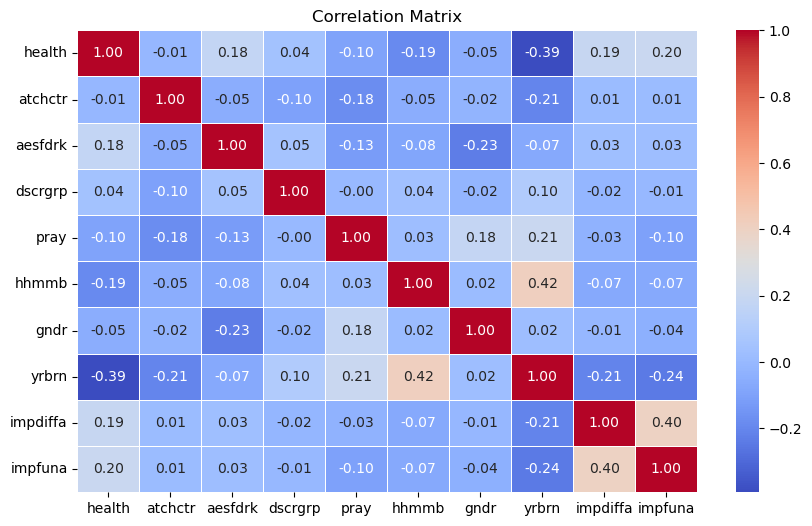

,health,atchctr,aesfdrk,dscrgrp,pray,hhmmb,gndr,yrbrn,impdiffa,impfuna
health,1.0,,,,,,,-0.392535,,
atchctr,,1.0,,,,,,,,
aesfdrk,,,1.0,,,,,,,
dscrgrp,,,,1.0,,,,,,
pray,,,,,1.0,,,,,
hhmmb,,,,,,1.0,,0.417705,,
gndr,,,,,,,1.0,,,
yrbrn,-0.392535,,,,,0.417705,,1.0,,
impdiffa,,,,,,,,,1.0,0.396887
impfuna,,,,,,,,,0.396887,1.0


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Построение матрицы корреляций
correlation_matrix = df[columns_to_analyze].corr()

# Отобразим корреляционную матрицу
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Определяем порог значимой корреляции (например, > 0.5 или < -0.5)
strong_correlation = correlation_matrix[(correlation_matrix > 0.3) | (correlation_matrix < -0.3)]
strong_correlation = strong_correlation.fillna("")  # Заполняем NaN пустыми строками для удобства
strong_correlation

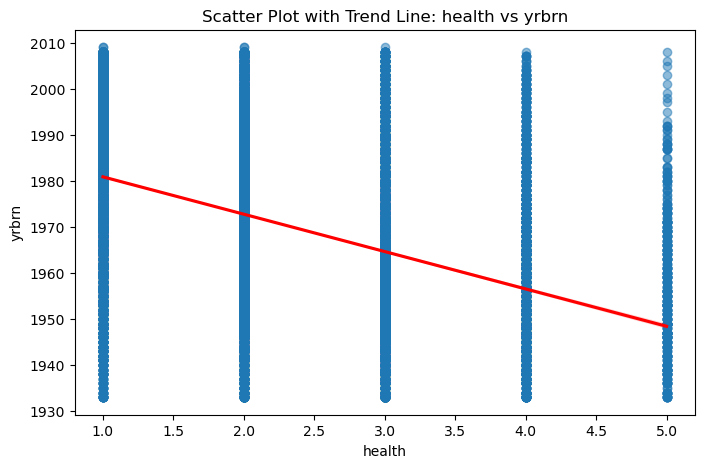

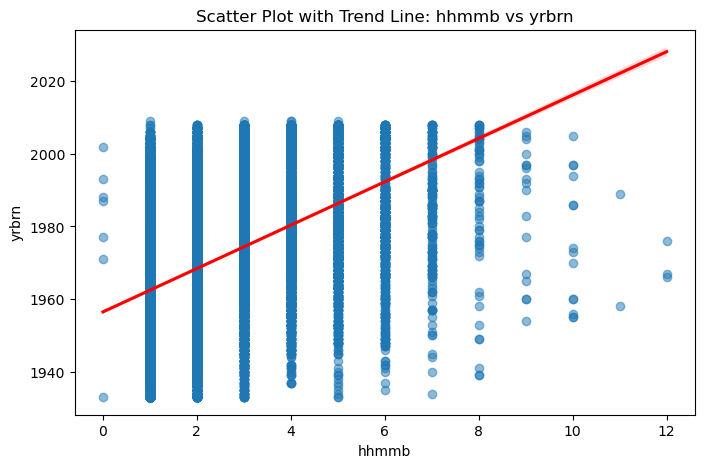

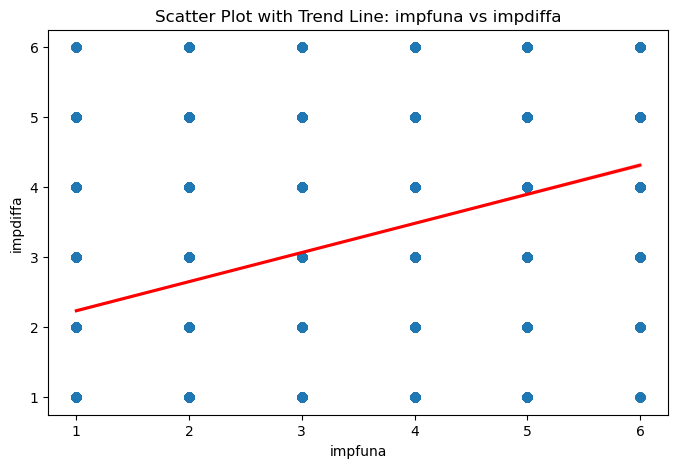

In [23]:
correlated_pairs = [
    ("health", "yrbrn"),
    ("hhmmb", "yrbrn"),
    ("impfuna", "impdiffa")
]

# Построение графиков рассеивания с трендовыми линиями для значимых корреляций
for x_var, y_var in correlated_pairs:
    plt.figure(figsize=(8, 5))
    sns.regplot(data=df, x=x_var, y=y_var, scatter_kws={'alpha': 0.5}, line_kws={"color": "red"})
    plt.title(f"Scatter Plot with Trend Line: {x_var} vs {y_var}")
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.show()